Práctica 2 (parte 1)
# Aproximación de una función con un perceptrón multicapa

In [69]:
# Realizamos las importaciones necesarias
import numpy as np
import matplotlib.pyplot as plt
import math


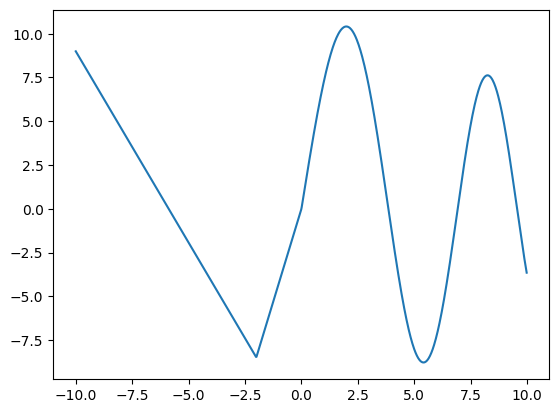

In [70]:
# Representamos la función que vamos a aproximar
def f(x):
    if x >= -10 and x < -2:
        return -2.186 * x - 12.864
    elif x >= -2 and x < 0:
        return 4.246 * x
    elif x >= 0 and x < 10:
        return 19 * np.exp(-0.05 * x - 0.5) * np.sin(0.03 * x**2 + 0.7 * x)
    else:
        return float("nan")


# Representación de la función
x = np.linspace(-10, 10, 1000)
f_np = np.vectorize(
    f
)  # Vectorizamos la función para poder aplicarla a un array de numpy
y = f_np(x)
plt.plot(x, y)
plt.show()


Definimos algunas funciones de transferencia:

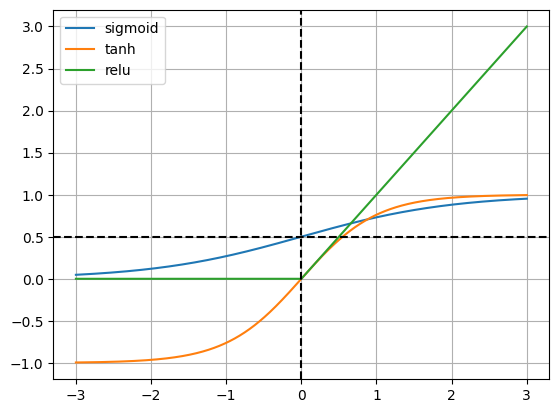

In [71]:
# Funciones de transferencia:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def tanh(x):
    return np.tanh(x)


def relu(x):
    return np.maximum(0, x)


# Las representamos con un gráfico
x = np.linspace(-3, 3, 1000)
y_sigmoid = sigmoid(x)
y_tanh = tanh(x)
y_relu = relu(x)
plt.plot(x, y_sigmoid, label="sigmoid")
plt.plot(x, y_tanh, label="tanh")
plt.plot(x, y_relu, label="relu")
plt.axvline(x=0, color="black", linestyle="--")
plt.axhline(y=0.5, color="black", linestyle="--")
plt.grid()
plt.legend()
plt.show()


# Calculamos también sus derivadas
def derivada_sigmoid(x):
    return np.exp(-x) / (2 * np.exp(-x) + np.exp(-x) ** 2 + 1)


def derivada_tanh(x):
    return -(np.tanh(x) ** 2) + 1


def derivada_relu(x):
    return np.where(x == 0, 0, 1)


La arquitectura de la red neuronal que vamos a utilizar es la que se define aquí:

In [72]:
# Definición de la arquitectura de la red neuronal:

train_percent = 0.8
cantidad_puntos = 200
neuronas_ocultas = 10
cte_aprendizaje = 0.0001
iteraciones = 80

Creamos el conjunto de datos que luego usaremos para el entrenamiento

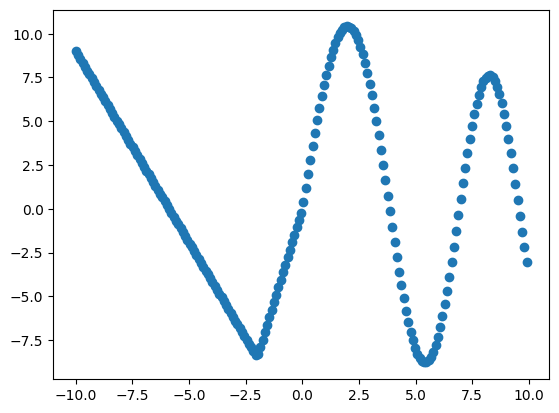

In [73]:
# Creación del dataset:

x_data = np.linspace(-10, 10, cantidad_puntos) # Para puntos equidistantes
# x_data = np.random.uniform(-10, 10, cantidad_puntos) # Para puntos aleatorios
y_data = f_np(x_data)
data = np.array([x_data, y_data]).T
np.random.shuffle(data)

# Representación del dataset
plt.scatter(data[:, 0], data[:, 1])
plt.show()


Separamos los datos disponibles en entrenamiento y test

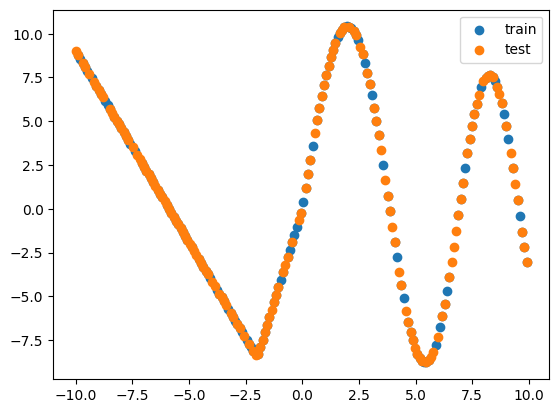

In [74]:
# Creacion de entrenamiento y test
train_data = data[: int(train_percent * cantidad_puntos)]
test_data = data[int((1 - train_percent) * cantidad_puntos) :]

# Extraer las características (x) y las etiquetas (y) para entrenamiento y test
x_train = train_data[:, 0].reshape(-1, 1)  # Cambiar la forma de x_train
y_train = train_data[:, 1].reshape(-1, 1)  # Cambiar la forma de y_train

x_test = test_data[:, 0].reshape(-1, 1)  # Cambiar la forma de x_test
y_test = test_data[:, 1].reshape(-1, 1)  # Cambiar la forma de y_test

# Representación de datos de entrenamiento y test
plt.scatter(x_train, y_train, label="train")
plt.scatter(x_test, y_test, label="test")
plt.legend()
plt.show()

Entrenamos la red neuronal

In [75]:
# Entrenamiento del perceptrón multicapa con la regla delta generalizada

# A diferencia de otras prácticas, vamos a usar orientación a objetos para la implementación de la red neuronal


import numpy as np

class MLP:
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        transfer_function: callable,
        transfer_function_derivative: callable,
        learning_rate: float = 0.1,
    ):
        # Inicializamos los pesos para la capa oculta y la capa de salida
        self.weights_hidden = np.random.rand(input_size, hidden_size)
        self.bias_hidden = np.zeros((1, hidden_size))
        self.weights_output = np.random.rand(hidden_size, 1)
        self.bias_output = np.zeros((1, 1))
        self.learning_rate = learning_rate
        self.transfer_function = transfer_function
        self.transfer_function_derivative = transfer_function_derivative

    def forward(self, inputs):
        # Propagación hacia adelante
        self.hidden_layer_input = np.dot(inputs, self.weights_hidden) + self.bias_hidden
        self.hidden_layer_output = self.transfer_function(self.hidden_layer_input)
        self.output_layer_input = np.dot(self.hidden_layer_output, self.weights_output) + self.bias_output
        self.output = self.transfer_function(self.output_layer_input)
        return self.output

    def backward(self, inputs, expected_output):
        # Retropropagación del error
        output_error = expected_output - self.output
        d_output = output_error * self.transfer_function_derivative(self.output)

        hidden_layer_error = np.dot(d_output, self.weights_output.T)
        d_hidden_layer = hidden_layer_error * self.transfer_function_derivative(self.hidden_layer_output)

        # Actualización de pesos y umbrales
        self.weights_output += np.dot(self.hidden_layer_output.T, d_output) * self.learning_rate
        self.bias_output += np.sum(d_output, axis=0, keepdims=True) * self.learning_rate
        self.weights_hidden += np.dot(inputs.T, d_hidden_layer) * self.learning_rate
        self.bias_hidden += np.sum(d_hidden_layer, axis=0, keepdims=True) * self.learning_rate

    def train(self, training_inputs, training_outputs, iterations):
        for _ in range(iterations):
            for inputs, expected_output in zip(training_inputs, training_outputs):
                inputs = np.array([inputs])  # Si las entradas ya están en forma de matriz, no es necesario convertirlas
                expected_output = np.array([expected_output])
                self.forward(inputs)
                self.backward(inputs, expected_output)

    def predict(self, inputs):
        return self.forward(inputs)


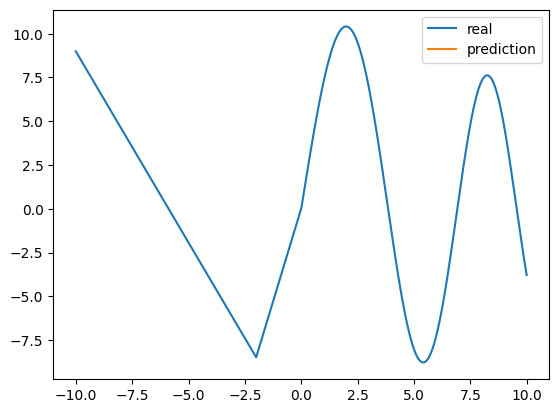

In [76]:
# Entrenamos de este modo la red neuronal
mlp = MLP(
    1, neuronas_ocultas, sigmoid, derivada_sigmoid, cte_aprendizaje
)

mlp.train(x_train.reshape(-1, 1), y_train.reshape(-1, 1), iteraciones)

# Realizamos predicciones
y_train_pred = mlp.predict(x_train.reshape(-1, 1)).flatten()
y_test_pred = mlp.predict(x_test.reshape(-1, 1)).flatten()

# Dibujamos la forma en la que la red neuronal ha aprendido la función
x = np.linspace(-10, 10, 10000)

plt.plot(x, f_np(x), label="real")
plt.plot(x, mlp.predict(x.reshape(-1, 1)), label="prediction")
plt.legend()
plt.show()